# Dyn and Thermo effects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp 
%matplotlib inline

In [2]:
from functions import ccplot

In [3]:
from tqdm.notebook import tnrange, tqdm
from scipy import integrate
from time import sleep

In [4]:
# import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
# plt.style.use(['science', 'notebook'])
plt.style.use('tableau-colorblind10')

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='BrBG', cmap_sequential='YlGnBu')

In [6]:
fsize = 15
tsize = 18

tdir = 'out'

major = 5.0
minor = 3.0

# plt.style.use(style)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['legend.handlelength'] = 1.0

In [7]:
# making a new colomap -> tmap

n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu_r
lower = cmap(np.linspace(0, diff, n))
lower2 = cmap2(np.linspace(0, diff, n))
white = np.ones((5, 4))
white2 = np.ones((5, 4))
upper = cmap(np.linspace(1-diff, 1, n))
upper2 = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, upper))
colors2 = np.vstack((lower2, white2, upper2))
tmap = m.colors.LinearSegmentedColormap.from_list('map_white', colors)
tmap2 = m.colors.LinearSegmentedColormap.from_list('map_white', colors2)

In [8]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((1, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, upper))
BrBU = m.colors.LinearSegmentedColormap.from_list('map_white', colors)

In [9]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

blues = cm.get_cmap('Blues', 256)
newcolors = blues(np.linspace(0, 1, 256))
white = np.array([0.95, 0.95, 0.95, 1])
newcolors[:25, :] = white
newblues = ListedColormap(newcolors)

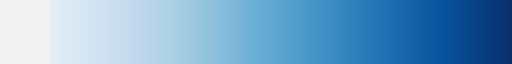

In [10]:
newblues

### Functions

In [11]:
def get_events_precip(p95, preciparr):
    idxs = np.where(preciparr >= p95)
    events = preciparr[idxs]
    return events, idxs

# util function to calculate value of qs
def get_qs(temp, pres):
    a1 = 6.1114
    temp0 = 273.16
    a3w = 17.269
    a4w = 35.86
    a3i = 21.875
    a4i = 7.66

    # calculating saturation vapor pressure using temperature values
    if temp > temp0:
        a3 = a3w
        a4 = a4w
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    elif temp < temp0 - 23:
        a3 = a3i
        a4 = a4i
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    else:
        esw = a1 * np.exp(a3w * ((temp - temp0)/(temp - a4w)))
        esi = a1 * np.exp(a3i * ((temp - temp0)/(temp - a4i)))
        es = esi + ((esw - esi)*(((temp - (temp0 - 23))/23)**2))

    # get saturation specific humidity value
    epsilon = 0.622
    qs = (epsilon * es) / (pres - ((1 - epsilon)*es))
    return qs

# vert integral function (Simpson's method)
def vert_integ(x, y):
    int = integrate.simpson(y, x, even='avg')

    return int

# finite differnce methods to find derivative
def centered_diff(arr):
    arr_diff = np.empty(len(arr) - 2)
    for i in range((len(arr) - 2)):
        arr_diff[i] = arr[i+2] - arr[i]
    return arr_diff

def forward_diff(arr):
    arr_diff = np.diff(arr)
    return arr_diff

def backward_diff(arr):
    arr_diff = -(np.diff(arr[::-1])[::-1])
    return arr_diff

def get_pe1(temp, omega, pres):
    pres_range = len(pres)
    time_range = len(temp)
    pe = np.empty(time_range)
    thermo = np.empty(time_range)

    p_cdiff = centered_diff(pres)
    p_fdiff = forward_diff(pres)
    p_bdiff = backward_diff(pres)

    # taking mean omega of all extremes to get the thermodynamic contribution
    qs = np.empty(pres_range)
    omega_mean = omega.mean(dim='time')

    for i in range(time_range):
        for j in range(pres_range):
            qs[j] = get_qs(temp[i, j], pres[j])
        qs_cdiff = centered_diff(qs)/(p_cdiff)
        qs_fdiff = forward_diff(qs)/(p_fdiff)
        qs_bdiff = backward_diff(qs)/(p_bdiff)

        qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
        qs_diff = np.append(qs_diff, qs_bdiff[-1])

        # TODO VARY: the value of 3600 will change for different time calculations
        # 1 hour -> 3600s
        # 3 hour -> 3600*3 and so on
        # '+' sign as pressure is from surface-to-top and not top-to-surface
        pe[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega[i]*qs_diff)) * 3600
        thermo[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega_mean*qs_diff)) * 3600

    dyn = pe - thermo
    return pe, dyn, thermo

def get_pe2(omega, q, pres):
    pres_range = len(pres)
    time_range = len(omega)
    pe = np.empty(time_range)
    thermo = np.empty(time_range)

    p_cdiff = centered_diff(pres)
    p_fdiff = forward_diff(pres)
    p_bdiff = backward_diff(pres)

    # taking mean omega of all extremes to get the thermodynamic contribution
#     qs = np.empty(pres_range)
    omega_mean = omega.mean(dim='time')

    for i in range(time_range):
#         for j in range(pres_range):
#             qs[j] = get_qs(temp[i, j], pres[j])
        q_cdiff = centered_diff(q[i])/(p_cdiff)
        q_fdiff = forward_diff(q[i])/(p_fdiff)
        q_bdiff = backward_diff(q[i])/(p_bdiff)

        q_diff = np.insert(q_cdiff, 0, q_fdiff[0])
        q_diff = np.append(q_diff, q_bdiff[-1])

        # TODO VARY: the value of 3600 will change for different time calculations
        # 1 hour -> 3600s
        # 3 hour -> 3600*3 and so on
        # '+' sign as pressure is from surface-to-top and not top-to-surface
        pe[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega[i]*q_diff)) * 3600
        thermo[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega_mean*q_diff)) * 3600

    dyn = pe - thermo
    return pe, dyn, thermo

def get_pe_final(omega, q, pres, omega_clim):
    pres_range = len(pres)
    time_range = len(omega)
    pe = np.empty(time_range)
    thermo = np.empty(time_range)

    p_cdiff = centered_diff(pres)
    p_fdiff = forward_diff(pres)
    p_bdiff = backward_diff(pres)

    # taking mean omega of all extremes to get the thermodynamic contribution
#     qs = np.empty(pres_range)
#     omega_mean = omega.mean(dim='time')

    for i in range(time_range):
#         for j in range(pres_range):
#             qs[j] = get_qs(temp[i, j], pres[j])
        q_cdiff = centered_diff(q[i])/(p_cdiff)
        q_fdiff = forward_diff(q[i])/(p_fdiff)
        q_bdiff = backward_diff(q[i])/(p_bdiff)

        q_diff = np.insert(q_cdiff, 0, q_fdiff[0])
        q_diff = np.append(q_diff, q_bdiff[-1])

        # TODO VARY: the value of 3600 will change for different time calculations
        # 1 hour -> 3600s
        # 3 hour -> 3600*3 and so on
        # '+' sign as pressure is from surface-to-top and not top-to-surface
        pe[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega[i]*q_diff)) * 3600
        thermo[i] = np.abs((-1/(9.806)) * vert_integ(pres, omega_clim*q_diff)) * 3600

    dyn = pe - thermo
    return pe, dyn, thermo

In [12]:
# def get_spatial_pe(precip, vimd, cape, u850, v850, q850, duration=24):
# def get_spatial_pe(precip, rvo, vimtu, vimtv, vimt, duration=24):
def get_spatial_pe(precip, duration=24):
    print("Starting...")

#     time_range = len(precip)
    xrange = len(precip[0])
    yrange = len(precip[0][0])

    # initialising the for loop by making zeros array
    precip95 = np.empty((xrange, yrange))
    precip_median = np.empty((xrange, yrange))
    precip_anom = np.empty((xrange, yrange))
    #
#     pe_median = np.empty((xrange, yrange))
#     pe_anom = np.empty((xrange, yrange))
    #
#     dyn_median = np.empty((xrange, yrange))
#     dyn_anom = np.empty((xrange, yrange))
    #
#     thermo_median = np.empty((xrange, yrange))
#     thermo_anom = np.empty((xrange, yrange))
    #
#     t2m_median = np.empty((xrange, yrange))
#     t2m_anom = np.empty((xrange, yrange))
#     d2m_median = np.empty((xrange, yrange))
#     d2m_anom = np.empty((xrange, yrange))
    #
    frequency = np.empty((xrange, yrange))
    #
    # vimd_median = np.empty((xrange, yrange))
    # vimd_anom = np.empty((xrange, yrange))
#     vimtu_median = np.empty((xrange, yrange))
#     vimtu_anom = np.empty((xrange, yrange))
#     vimtv_median = np.empty((xrange, yrange))
#     vimtv_anom = np.empty((xrange, yrange))
#     vimt_median = np.empty((xrange, yrange))
#     vimt_anom = np.empty((xrange, yrange))
    # cape_median = np.empty((xrange, yrange))
    # cape_anom = np.empty((xrange, yrange))
#     omega_median = np.empty((xrange, yrange))
#     omega_anom = np.empty((xrange, yrange))
    # u850_median = np.empty((xrange, yrange))
    # u850_anom = np.empty((xrange, yrange))
    # v850_median = np.empty((xrange, yrange))
    # v850_anom = np.empty((xrange, yrange))
    # llmtu_median = np.empty((xrange, yrange))
    # llmtu_anom = np.empty((xrange, yrange))
    # llmtv_median = np.empty((xrange, yrange))
    # llmtv_anom = np.empty((xrange, yrange))
    # ws850_median = np.empty((xrange, yrange))
    # ws850_anom = np.empty((xrange, yrange))
    # llmt_median = np.empty((xrange, yrange))
    # llmt_anom = np.empty((xrange, yrange))
#     rvo200_median = np.empty((xrange, yrange))
#     rvo200_anom = np.empty((xrange, yrange))
#     rvo500_median = np.empty((xrange, yrange))
#     rvo500_anom = np.empty((xrange, yrange))
#     rvo850_median = np.empty((xrange, yrange))
#     rvo850_anom = np.empty((xrange, yrange))
    #
    print("Starting the loop ...")

    # starting loop
    for lat in tqdm(range(xrange)):
        for lon in tqdm(range(yrange), leave = False):
            preciparr = precip.isel(lat = lat, lon = lon)
#             temparr = temp.isel(lat = lat, lon = lon)
#             t2marr = t2m.isel(lat = lat, lon = lon)
#             d2marr = d2m.isel(lat = lat, lon = lon)
#             omegaarr = omega850.isel(lat = lat, lon = lon)
            # vimdarr = vimd.isel(lat = lat, lon = lon)
#             vimtarr = vimt.isel(lat = lat, lon = lon)
#             vimtuarr = vimtu.isel(lat = lat, lon = lon)
#             vimtvarr = vimtv.isel(lat = lat, lon = lon)
            # capearr = cape.isel(lat = lat, lon = lon)
            # qarr = q850.isel(lat = lat, lon = lon)
            # uarr = u850.isel(lat = lat, lon = lon)
            # varr = v850.isel(lat = lat, lon = lon)
#             rvo200arr = rvo.sel(level = 200).isel(lat = lat, lon = lon)
#             rvo500arr = rvo.sel(level = 500).isel(lat = lat, lon = lon)
#             rvo850arr = rvo.sel(level = 850).isel(lat = lat, lon = lon)
            # getting climatology
            precip_clim = preciparr.mean(dim = 'time').to_numpy()
#             t2m_clim = t2marr.mean(dim='time').to_numpy()
#             d2m_clim = d2marr.mean(dim = 'time').to_numpy()
#             omega_clim = omegaarr.mean(dim='time').to_numpy()
            # vimd_clim = vimdarr.mean(dim = 'time').to_numpy()
#             vimt_clim = vimtarr.mean(dim = 'time').to_numpy()
#             vimtu_clim = vimtuarr.mean(dim = 'time').to_numpy()
#             vimtv_clim = vimtvarr.mean(dim = 'time').to_numpy()
            # cape_clim = capearr.mean(dim = 'time').to_numpy()
            # q850_clim = qarr.mean(dim = 'time').to_numpy()
            # u850_clim = uarr.mean(dim = 'time').to_numpy()
            # v850_clim = varr.mean(dim = 'time').to_numpy()
            # ws850_clim = np.sqrt(u850_clim**2 + v850_clim**2)
            # llmtu_clim = q850_clim*u850_clim
            # llmtv_clim = q850_clim*v850_clim
            # llmt_clim = q850_clim*ws850_clim
#             rvo200_clim = rvo200arr.mean(dim = 'time').to_numpy()
#             rvo500_clim = rvo500arr.mean(dim = 'time').to_numpy()
#             rvo850_clim = rvo850arr.mean(dim = 'time').to_numpy()
            # start
            p95 = preciparr.quantile(0.95, interpolation='higher')
            precip_events, precip_idxs = get_events_precip(p95, preciparr[~np.isnan(preciparr)])
#             temp_events = temparr[~np.isnan(preciparr)][precip_idxs]
#             t2m_events = t2marr[~np.isnan(preciparr)][precip_idxs]
#             d2m_events = d2marr[~np.isnan(preciparr)][precip_idxs]
#             omega_events = omegaarr[~np.isnan(preciparr)][precip_idxs]
            # vimd_events = vimdarr[~np.isnan(preciparr)][precip_idxs]
#             vimt_events = vimtarr[~np.isnan(preciparr)][precip_idxs]
#             vimtu_events = vimtuarr[~np.isnan(preciparr)][precip_idxs]
#             vimtv_events = vimtvarr[~np.isnan(preciparr)][precip_idxs]
            # cape_events = capearr[~np.isnan(preciparr)][precip_idxs]
            # u850_events = uarr[~np.isnan(preciparr)][precip_idxs]
            # v850_events = varr[~np.isnan(preciparr)][precip_idxs]
            # q850_events = qarr[~np.isnan(preciparr)][precip_idxs]
            # ws850_events = np.sqrt(u850_events**2 + v850_events**2)
            # llmtu_events = q850_events*u850_events
            # llmtv_events = q850_events*v850_events
            # llmt_events = q850_events*ws850_events
#             rvo200_events = rvo200arr[~np.isnan(preciparr)][precip_idxs]
#             rvo500_events = rvo500arr[~np.isnan(preciparr)][precip_idxs]
#             rvo850_events = rvo850arr[~np.isnan(preciparr)][precip_idxs]
#             pe, dyn, thermo = get_pe_final(omega_events, q_events, pres, omega_clim)
            # returns
            precip95[lat, lon] = p95
            frequency[lat, lon] = len(precip_events)
            precip_median[lat, lon] = np.median(precip_events)
            precip_anom[lat, lon] = np.mean((precip_events - precip_clim))
#             t2m_median[lat, lon] = np.median(t2m_events)
#             t2m_anom[lat, lon] = np.mean((t2m_events - t2m_clim))
#             d2m_median[lat, lon] = np.median(d2m_events)
#             d2m_anom[lat, lon] = np.mean((d2m_events - d2m_clim))
#             pe_median[lat, lon] = np.median(pe*duration)
#             pe_anom[lat, lon] = np.mean((pe*duration - precip_clim))
#             dyn_median[lat, lon] = np.median(dyn*duration)
#             dyn_anom[lat, lon] = np.mean((dyn*duration - precip_clim))
#             thermo_median[lat, lon] = np.median(thermo*duration)
#             thermo_anom[lat, lon] = np.mean((thermo*duration - precip_clim))
            # vimd_median[lat, lon] = np.median(vimd_events)
            # vimd_anom[lat, lon] = np.mean((vimd_events - vimd_clim))
#             vimt_median[lat, lon] = np.median(vimt_events)
#             vimt_anom[lat, lon] = np.mean((vimt_events - vimt_clim))
#             vimtu_median[lat, lon] = np.median(vimtu_events)
#             vimtu_anom[lat, lon] = np.mean((vimtu_events - vimtu_clim))
#             vimtv_median[lat, lon] = np.median(vimtv_events)
#             vimtv_anom[lat, lon] = np.mean((vimtv_events - vimtv_clim))
#             omega_median[lat, lon] = np.median(omega_events)
#             omega_anom[lat, lon] = np.mean((omega_events - omega_clim))
            # cape_median[lat, lon] = np.median(cape_events)
            # cape_anom[lat, lon] = np.mean((cape_events - cape_clim))
            # u850_median[lat, lon] = np.median(u850_events)                                   
            # u850_anom[lat, lon] = np.mean((u850_events - u850_clim))
            # v850_median[lat, lon] = np.median(v850_events)
            # v850_anom[lat, lon] = np.mean((v850_events - v850_clim))
            # ws850_median[lat, lon] = np.median(ws850_events)
            # ws850_anom[lat, lon] = np.mean((ws850_events - ws850_clim))
            # llmtu_median[lat, lon] = np.median(llmtu_events)
            # llmtu_anom[lat, lon] = np.mean((llmtu_events - llmtu_clim))
            # llmtv_median[lat, lon] = np.median(llmtv_events)
            # llmtv_anom[lat, lon] = np.mean((llmtv_events - llmtv_clim))
            # llmt_median[lat, lon] = np.median(llmt_events)
            # llmt_anom[lat, lon] = np.mean((llmt_events - llmt_clim))
#             rvo200_median[lat ,lon] = np.median(rvo200_events)
#             rvo200_anom[lat ,lon] = np.mean((rvo200_events - rvo200_clim))
#             rvo500_median[lat ,lon] = np.median(rvo500_events)
#             rvo500_anom[lat ,lon] = np.mean((rvo500_events - rvo500_clim))
#             rvo850_median[lat ,lon] = np.median(rvo850_events)
#             rvo850_anom[lat ,lon] = np.mean((rvo850_events - rvo850_clim))
            sleep(0.01)
                                                                             
    res = {
        'precip_95':precip95,
        'precip_median':precip_median,
        'precip_anom':precip_anom,
#         't2m_median':t2m_median,
#         't2m_anom':t2m_anom,
#         'd2m_median':d2m_median,
#         'd2m_anom':d2m_anom,
#         'pe_median':pe_median,
#         'pe_anom':pe_anom,
#         'dyn_median':dyn_median,
#         'dyn_anom':dyn_anom,
#         'thermo_median':thermo_median,
#         'thermo_anom':thermo_anom,
        'frequency':frequency,
        # 'vimd_median':vimd_median,
        # 'vimd_anom':vimd_anom,
#         'vimt_median':vimt_median,
#         'vimt_anom':vimt_anom,
#         'vimtu_median':vimtu_median,
#         'vimtu_anom':vimtu_anom,
#         'vimtv_median':vimtv_median,
#         'vimtv_anom':vimtv_anom,
        # 'cape_median':cape_median,
        # 'cape_anom':cape_anom,
#         'omega_median':omega_median,
#         'omega_anom':omega_anom,
        # 'u850_median':u850_median,
        # 'u850_anom':u850_anom,
        # 'v850_median':v850_median,
        # 'v850_anom':v850_anom,
        # 'ws850_median':ws850_median,
        # 'ws850_anom':ws850_anom,
        # 'llmtu_median':llmtu_median,
        # 'llmtu_anom':llmtu_anom,
        # 'llmtv_median':llmtv_median,
        # 'llmtv_anom':llmtv_anom,
        # 'llmt_median':llmt_median,
        # 'llmt_anom':llmt_anom
#         'rvo200_median':rvo200_median,
#         'rvo200_anom':rvo200_anom,
#         'rvo500_median':rvo500_median,
#         'rvo500_anom':rvo500_anom,
#         'rvo850_median':rvo850_median,
#         'rvo850_anom':rvo850_anom,
    }
    return res

In [13]:
# def get_spatial_pe(precip, vimd, cape, u850, v850, q850, duration=24):
def get_dyn_thermo(precip, omega, q, pres, duration=24):
    print("Starting...")

#     time_range = len(precip)
    xrange = len(precip[0])
    yrange = len(precip[0][0])

    # initialising the for loop by making zeros array
    precip95 = np.empty((xrange, yrange))
    precip_median = np.empty((xrange, yrange))
    precip_anom = np.empty((xrange, yrange))
    #
    pe_median = np.empty((xrange, yrange))
    pe_anom = np.empty((xrange, yrange))
    #
    dyn_median = np.empty((xrange, yrange))
    dyn_anom = np.empty((xrange, yrange))
    #
    thermo_median = np.empty((xrange, yrange))
    thermo_anom = np.empty((xrange, yrange))
    #
    omega_median = np.empty((xrange, yrange))
    omega_anom = np.empty((xrange, yrange))
    #
    q_median = np.empty((xrange, yrange))
    q_anom = np.empty((xrange, yrange))
    #
    print("Starting the loop ...")

    # starting loop
    for lat in tqdm(range(xrange)):
        for lon in tqdm(range(yrange), leave = False):
            preciparr = precip.isel(lat = lat, lon = lon)
            temparr = temp.isel(lat = lat, lon = lon)
            omegaarr = omega.isel(lat = lat, lon = lon)
            qarr = q.isel(lat = lat, lon = lon)
            # getting climatology
            precip_clim = preciparr.mean(dim = 'time').to_numpy()
            omega_clim = omegaarr.mean(dim='time').to_numpy()
            q_clim = qarr.mean(dim = 'time').to_numpy()
            # start
            p95 = preciparr.quantile(0.95, interpolation='higher')
            precip_events, precip_idxs = get_events_precip(p95, preciparr[~np.isnan(preciparr)])
            temp_events = temparr[~np.isnan(preciparr)][precip_idxs]
            omega_events = omegaarr[~np.isnan(preciparr)][precip_idxs]
            q_events = qarr[~np.isnan(preciparr)][precip_idxs]
            pe, dyn, thermo = get_pe_final(omega_events, q_events, pres, omega_clim)
            # returns
            precip95[lat, lon] = p95
            precip_median[lat, lon] = np.median(precip_events)
            precip_anom[lat, lon] = np.mean((precip_events - precip_clim))
            pe_median[lat, lon] = np.median(pe*duration)
            pe_anom[lat, lon] = np.mean((pe*duration - precip_clim))
            dyn_median[lat, lon] = np.median(dyn*duration)
            dyn_anom[lat, lon] = np.mean((dyn*duration - precip_clim))
            thermo_median[lat, lon] = np.median(thermo*duration)
            thermo_anom[lat, lon] = np.mean((thermo*duration - precip_clim))
            omega_median[lat, lon] = np.median(omega_events.mean(dim='level'))
            omega_anom[lat, lon] = np.mean((omega_events - omega_clim))
            q_median[lat, lon] = np.median(q_events.mean(dim='level'))
            q_anom[lat, lon] = np.mean((q_events - q_clim))
            sleep(0.01)
                                                                             
    res = {
        'precip_95':precip95,
        'precip_median':precip_median,
        'precip_anom':precip_anom,
        'pe_median':pe_median,
        'pe_anom':pe_anom,
        'dyn_median':dyn_median,
        'dyn_anom':dyn_anom,
        'thermo_median':thermo_median,
        'thermo_anom':thermo_anom,
        'omega_median':omega_median,
        'omega_anom':omega_anom,
        'q_median':q_median,
        'q_anom':q_anom,
    }
    return res

In [14]:
imd_precip = xr.open_mfdataset('./data/imd_precip/*.nc', chunks=dict(time=1000, lat=40, lon=40))
# imd_precip = imd_precip.tranpose('TIME', 'LATITUDE', 'LONGITUDE')
imd_precip = imd_precip.rename_dims({'TIME':'time', 'LATITUDE':'lat', 'LONGITUDE':'lon'})
imd_precip = imd_precip.rename({'TIME':'time', 'LATITUDE':'lat', 'LONGITUDE':'lon'})
# imd_precip = imd_precip.isel(lat = 70, lon = 74)
imd_precip

<xarray.Dataset>
Dimensions:   (lon: 135, lat: 129, time: 7671)
Coordinates:
  * lon       (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * lat       (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    RAINFALL  (time, lat, lon) float64 dask.array<chunksize=(366, 129, 135), meta=np.ndarray>
Attributes:
    history:      FERRET V7.5 (optimized) 16-Mar-22
    Conventions:  CF-1.6

In [14]:
gpm = xr.open_mfdataset('./data/GPM_lowres_data/*.nc', chunks=dict(time=1000, lat=40, lon=40))
gpm = gpm.sel(time = slice("2000-06-01 00:00:00","2020-12-31 23:30:00"))
precip = (gpm.precipCal.resample(time = '24H').sum() / 2)
precip

,Array,Chunk
Bytes,743.48 MiB,6.25 kiB
Shape,"(7519, 161, 161)","(1, 40, 40)"
Count,1375022 Tasks,187975 Chunks
Type,float32,numpy.ndarray


In [14]:
era_precip = xr.open_mfdataset('./data/era_precip/*.nc', chunks=dict(time=1000, lat=40, lon=40))
# era = era.sel(expver=1, drop=True)
era_precip = era_precip.transpose('time', 'latitude', 'longitude')
era_precip = era_precip.rename_dims({'longitude':'lon', 'latitude':'lat'})
era_precip = era_precip.rename({'longitude':'lon', 'latitude':'lat'})
# era_precip = era_precip.sel(time = slice("2000-06-01 00:00:00","2020-12-31 23:00:00"))
# era_precip = era_precip.reindex(lat = era_precip.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
# era_precip = era_precip.isel(lat = slice(18, 20), lon= slice(70,74))
era_precip

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184104)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1000, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-17 10:21:10 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [15]:
# mfdata_DIR2 = './data/era_data/*.nc'
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40))
# # era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# # era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# # era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=1000, lat=40, lon=40))

In [16]:
# era = era.transpose('time', 'latitude', 'longitude')
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})
# era = era.rename({'longitude':'lon', 'latitude':'lat'})
# # era_pres = era_pres.reindex(lat = era_pres.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
# era

In [17]:
mfdata_DIR3 = './data/era_pres_data/*.nc'
era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=1000, lat=40, lon=40))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=1000, lat=40, lon=40))

In [18]:
era_pres = era_pres.transpose('time', 'level', 'latitude', 'longitude')
era_pres = era_pres.rename_dims({'longitude':'lon', 'latitude':'lat'})
era_pres = era_pres.rename({'longitude':'lon', 'latitude':'lat'})
# era_pres = era_pres.reindex(lat = era_pres.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
# era_pres = era_pres.isel(lat = slice(18, 20), lon= slice(70,74))
era_pres

C:\ProgramData\Anaconda3\lib\site-packages\dask\array\core.py:1472: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


,Array,Chunk
Bytes,515.55 GiB,-2130045376 B
Shape,"(184104, 29, 161, 161)","(720, 29, 161, 161)"
Count,1197 Tasks,399 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,515.55 GiB,-2130045376 B
Shape,"(184104, 29, 161, 161)","(720, 29, 161, 161)"
Count,1197 Tasks,399 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
mfdata_DIR4 = './data/era_data2/*.nc'
era2 = xr.open_mfdataset(mfdata_DIR4, chunks=dict(time=500, lat=10, lon=10))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))

In [8]:
# era2 = era2.sel(expver=1, drop=True)
era2 = era2.transpose('time', 'latitude', 'longitude')
era2 = era2.rename_dims({'longitude':'lon', 'latitude':'lat'})
era2 = era2.rename({'longitude':'lon', 'latitude':'lat'})
# era2 = era2.reindex(lat = era2.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
era2

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184104)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    e        (time, lat, lon) float32 dask.array<chunksize=(500, 161, 161), meta=np.ndarray>
    vimd     (time, lat, lon) float32 dask.array<chunksize=(500, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-04 12:51:49 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [11]:
mfdata_DIR5 = 'J:/msc_project/data/wind/*.nc'
era3 = xr.open_mfdataset(mfdata_DIR5, chunks=dict(time=500, lat=10, lon=10))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))
# era2 = era2.sel(expver=1, drop=True)
era3 = era3.transpose('time', 'level', 'latitude', 'longitude')
era3 = era3.rename_dims({'longitude':'lon', 'latitude':'lat'})
era3 = era3.rename({'longitude':'lon', 'latitude':'lat'})
# era3 = era3.reindex(lat = era3.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
era3

OSError: no files to open

In [21]:
mfdata_DIR6 = 'J:/msc_project/data/cape/*.nc'
era4 = xr.open_mfdataset(mfdata_DIR6, chunks=dict(time=500, lat=10, lon=10))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))
# era2 = era2.sel(expver=1, drop=True)
era4 = era4.transpose('time', 'latitude', 'longitude')
era4 = era4.rename_dims({'longitude':'lon', 'latitude':'lat'})
era4 = era4.rename({'longitude':'lon', 'latitude':'lat'})
# era4 = era4.reindex(lat = era4.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
era4

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184104)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    cape     (time, lat, lon) float32 dask.array<chunksize=(500, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-12 14:55:50 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [15]:
mfdata_DIR7 = './data/era_data3/wv_flux_*.nc'
era5 = xr.open_mfdataset(mfdata_DIR7, chunks=dict(time=500, lat=10, lon=10))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))
# era2 = era2.sel(expver=1, drop=True)
era5 = era5.transpose('time', 'latitude', 'longitude')
era5 = era5.rename_dims({'longitude':'lon', 'latitude':'lat'})
era5 = era5.rename({'longitude':'lon', 'latitude':'lat'})
# era4 = era4.reindex(lat = era4.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
era5

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184104)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    p71.162  (time, lat, lon) float32 dask.array<chunksize=(500, 161, 161), meta=np.ndarray>
    p72.162  (time, lat, lon) float32 dask.array<chunksize=(500, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-17 14:48:14 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [16]:
mfdata_DIR8 = './data/era_rvo/rvo*.nc'
era6 = xr.open_mfdataset(mfdata_DIR8, chunks=dict(time=500, lat=10, lon=10))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))
# era2 = era2.sel(expver=1, drop=True)
era6 = era6.transpose('time', 'level', 'latitude', 'longitude')
era6 = era6.rename_dims({'longitude':'lon', 'latitude':'lat'})
era6 = era6.rename({'longitude':'lon', 'latitude':'lat'})
# era4 = era4.reindex(lat = era4.lat[::-1]).chunk(dict(time=1000, lat =40, lon=40))
era6

,Array,Chunk
Bytes,53.33 GiB,148.32 MiB
Shape,"(184104, 3, 161, 161)","(500, 3, 161, 161)"
Count,777 Tasks,378 Chunks
Type,float32,numpy.ndarray


In [19]:
# xx, yy = np.meshgrid(era5['lon'], era5['lat'])

In [20]:
# plt.figure(figsize=(6,5))
# (np.sqrt(era5['p71.162'].isel(time = 84000)**2 + era5['p72.162'].isel(time = 84000)**2)).plot.contourf(cmap = 'Blues', levels=11)
# plt.quiver(xx[::7,::7], yy[::7,::7], era5['p71.162'][84000,::7,::7], era5['p72.162'][84000,::7,::7])

# Scratch

In [21]:
# era_precip = (era_precip.resample(time = '24H').sum()).chunk(dict(time=-1))
# era_pres = (era_pres.resample(time = '24H').mean()).chunk(dict(time=-1))

In [22]:
era_precip

<xarray.Dataset>
Dimensions:  (lon: 4, lat: 2, time: 184104)
Coordinates:
  * lon      (lon) float32 77.5 77.75 78.0 78.25
  * lat      (lat) float32 35.5 35.25
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1000, 2, 4), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-17 10:21:10 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [ ]:
era_precip_loaded = era_precip.load()
era_pres_loaded = era_pres.load()

In [29]:
precip = era_precip_loaded.tp*1000
temp = era_pres_loaded.t
omega = era_pres_loaded.w
q = era_pres_loaded.q

NameError: name 'era_precip_loaded' is not defined

In [ ]:
precip = precip.where(precip > 1)
temp = temp.where(precip > 1)
omega = omega.where(precip > 1)
q = q.where(precip > 1)

In [26]:
# p95 = precip.quantile(0.95, interpolation='higher')
# precip_ex = precip[precip > p95]
# temp_ex = temp[precip > p95]
# omega_ex = omega[precip > p95]
# q_ex = q[precip > p95]

In [27]:
# precip_ex

In [28]:
# pres = omega.coords['level'].to_numpy()
# pres

In [31]:
# pe, dyn, thermo = get_pe1(temp_ex, omega_ex, pres)

In [32]:
# pe2, dyn2, thermo2 = get_pe2(omega_ex, q_ex, pres)

In [29]:
# omega_clim = omega.mean(dim='time')
# pe_test, dyn_test, thermo_test = get_pe_test(omega_ex, q_ex, pres, omega_clim)

In [33]:
# dates = precip_ex.coords['time']
# dates

In [ ]:
# fig = plt.figure(figsize=(21,7))
# plt.plot(precip_ex[:50], ls='--', lw=1.5, color='k', alpha=0.5)
# plt.plot((pe*24)[:50], ls='-', lw=1.5, color='k', alpha=0.9)
# plt.plot((dyn*24)[:50], ls='-', lw=1.5, color='tab:blue', alpha=0.9)
# plt.plot((thermo*24)[:50], ls='-', lw=1.5, color='tab:red', alpha=0.9)
# plt.savefig('./images/dyn_thermo/new/first_50_extremes_using_qs.png', dpi=300)

In [ ]:
# fig = plt.figure(figsize=(21,7))
# plt.plot(precip_ex[:50], ls='--', lw=1.5, color='k', alpha=0.5)
# plt.plot((pe2*24)[:50], ls='-', lw=1.5, color='k', alpha=0.9)
# plt.plot((dyn2*24)[:50], ls='-', lw=1.5, color='tab:blue', alpha=0.9)
# plt.plot((thermo2*24)[:50], ls='-', lw=1.5, color='tab:red', alpha=0.9)
# plt.savefig('./images/dyn_thermo/new/first_50_extremes_using_q.png', dpi=300)

In [ ]:
# fig = plt.figure(figsize=(21,7))
# plt.plot(precip_ex[:50], ls='--', lw=1.5, color='k', alpha=0.5)
# plt.plot((pe_test*24)[:50], ls='-', lw=1.5, color='k', alpha=0.9)
# plt.plot((dyn_test*24)[:50], ls='-', lw=1.5, color='tab:blue', alpha=0.9)
# plt.plot((thermo_test*24)[:50], ls='-', lw=1.5, color='tab:red', alpha=0.9)
# plt.savefig('./images/dyn_thermo/new/first_50_extremes_using_omega_clim_and_q.png', dpi=300)

In [ ]:
# precip_ex = precip_ex[(pe*24) < 1000]
# pen = pe[(pe*24) < 1000]
# dynn = dyn[(pe*24) < 1000]
# thermon = thermo[(pe*24) < 1000]

# pe2n = pe2[(pe2*24) < 1000]
# dyn2n = dyn2[(pe2*24) < 1000]
# thermo2n = thermo2[(pe2*24) < 1000]

# pe_testn = pe_test[(pe_test*24) < 1000]
# dyn_testn = dyn_test[(pe_test*24) < 1000]
# thermo_testn = thermo_test[(pe_test*24) < 1000]

In [ ]:
# np.mean(precip_ex.to_numpy()), np.mean(pen*24), np.mean(dynn*24), np.mean(thermon*24)

In [ ]:
# np.mean(precip_ex.to_numpy()), np.mean(pe2n*24), np.mean(dyn2n*24), np.mean(thermo2n*24)

In [ ]:
# np.mean(precip_ex.to_numpy()), np.mean(pe_testn*24), np.mean(dyn_testn*24), np.mean(thermo_testn*24)

In [ ]:
# np.median(precip_ex.to_numpy()), np.median(pen*24), np.median(dynn*24), np.median(thermon*24)

In [ ]:
# np.median(precip_ex.to_numpy()), np.median(pe2n*24), np.median(dyn2n*24), np.median(thermo2n*24)

In [ ]:
# np.median(precip_ex.to_numpy()), np.median(pe_testn*24), np.median(dyn_testn*24), np.median(thermo_testn*24)

In [ ]:
# precip_ex.to_numpy()[25], (pen*24)[25], (dynn*24)[25], (thermon*24)[25]

In [ ]:
# precip_ex.to_numpy()[25], (pe2n*24)[25], (dyn2n*24)[25], (thermo2n*24)[25]

In [ ]:
# precip_ex.to_numpy()[25], (pe_testn*24)[25], (dyn_testn*24)[25], (thermo_testn*24)[25]

In [ ]:
# fig = plt.figure(figsize=(6,6))
# plt.boxplot([precip_ex.to_numpy(), (pen*24), (dynn*24), (thermon*24)], showmeans=True)
# plt.gca().set_xticklabels(['Precip_ex', 'Pe', 'Dyn', 'Thermo'])
# plt.savefig('./images/dyn_thermo/new/box_mumbai_using_qs.png', dpi=300)

In [ ]:
# fig = plt.figure(figsize=(6,6))
# plt.boxplot([precip_ex.to_numpy(), (pe2n*24), (dyn2n*24), (thermo2n*24)], showmeans=True)
# plt.gca().set_xticklabels(['Precip_ex', 'Pe', 'Dyn', 'Thermo'])
# plt.savefig('./images/dyn_thermo/new/box_mumbai_using_q.png', dpi=300)

In [ ]:
# fig = plt.figure(figsize=(6,6))
# plt.boxplot([precip_ex.to_numpy(), (pe_testn*24), (dyn_testn*24), (thermo_testn*24)], showmeans=True)
# plt.gca().set_xticklabels(['Precip_ex', 'Pe', 'Dyn', 'Thermo'])
# plt.savefig('./images/dyn_thermo/new/box_mumbai_using_omega_clim_and_q.png', dpi=300)

In [ ]:
# qs = np.empty((len(temp_ex), len(pres)))
# for i in range(len(temp_ex)):
#     for j in range(len(pres)):
#         qs[i, j] = get_qs(temp_ex[i, j], pres[j])
    
# qs

In [ ]:
# plt.figure(figsize=(5,7))
# # plt.plot(omega_ex[25], pres, ls = '-', color='tab:blue', lw=1.5, alpha=0.9, label='omega one event')
# plt.plot(omega_ex.mean(dim='time'), pres, ls = '-', color='k', lw=1.5, alpha=0.9, label='omega ext. clim.')
# plt.plot(omega.mean(dim='time'), pres, ls = '--', color='k', lw=1.5, alpha=0.9, label='omega overall clim.')
# # plt.plot(q_ex[25], pres, ls = '--', color='k', lw=1.5, alpha=0.9, label='q')
# # plt.plot(qs[25], pres, ls = '--', color='b', lw=1.5, alpha=0.9, label='qs')
# plt.legend(frameon=False, loc='upper left', fontsize=12)
# # plt.ylim(0, 1050)
# plt.gca().invert_yaxis()
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.xlabel(r'$\omega$ (Pa/s)')
# plt.ylabel(r'Pressure (Pa)')
# plt.savefig('./images/dyn_thermo/new/vert_profile_omega_mumbai_event.png', dpi=300)

In [34]:
# plt.figure(figsize=(5,7))
# # plt.plot(omega_ex[25], pres, ls = '-', color='k', lw=1.5, alpha=0.9, label='omega')
# plt.plot(q_ex.mean(dim = 'time'), pres, ls = '-', color='k', lw=1.5, alpha=0.9, label='q ext. clim.')
# plt.plot(np.mean(qs, axis=0), pres, ls = '--', color='k', lw=1.5, alpha=0.9, label='qs ext. clim.')
# plt.legend(frameon=False, fontsize=12)
# plt.gca().invert_yaxis()
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.xlabel(r'$q$ or $q_{s}$ (kg/kg)')
# plt.ylabel(r'Pressure (Pa)')
# plt.savefig('./images/dyn_thermo/new/vert_profile_q_qs_mumbai_event.png', dpi=300)

# Scratch ended

## get_dyn_thermo starts here

In [19]:
import warnings

In [20]:
pres = temp.coords['level'].to_numpy()
pres

NameError: name 'temp' is not defined

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = get_dyn_thermo(precip, omega, q, pres)

Starting...
Starting the loop ...


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
res.keys()

dict_keys(['precip_95', 'precip_median', 'precip_anom', 'pe_median', 'pe_anom', 'dyn_median', 'dyn_anom', 'thermo_median', 'thermo_anom', 'omega_median', 'omega_anom', 'q_median', 'q_anom'])

## get_spatial_pe starts here

In [17]:
# # t2m = era.t2m.resample(time = '24H').mean()
# # d2m = era.d2m.resample(time = '24H').mean()
# precip = (era_precip.tp*1000)
# # precip = precip.resample(time = '24H').sum()
# # t2m = era.t2m
# # d2m = era.d2m
# # temp = era_pres.t.resample(time = '24H').mean()
# omega = (era_pres.w.sel(level=850).drop('level'))
# vimd = era2.vimd
# cape = era4.cape
# u850 = (era3.u.sel(level=850).drop('level'))
# v850 = (era3.v.sel(level=850).drop('level'))
# q850 = (era_pres.q.sel(level=850).drop('level'))

precip = (era_precip.tp*1000).resample(time = '24H').sum()
vimtu = era5['p71.162'].resample(time = '24H').mean()
vimtv = era5['p72.162'].resample(time = '24H').mean()
vimt = np.sqrt(vimtu**2 + vimtv**2)
vimt = vimt.rename('vimt')
rvo = era6.vo.resample(time = '24H').mean()
# omega = era_pres.w
# vimd = era2.vimd
# cape = era4.cape
# u850 = (era3.u.sel(level=850).drop('level'))
# v850 = (era3.v.sel(level=850).drop('level'))
# q = era_pres.q

In [18]:
ds_comb = xr.merge([precip, vimt, vimtu, vimtv])
# ds_comb = xr.merge([precip, vimd, cape, u850, v850, q850])
# ds_comb = xr.merge([precip, t2m, d2m])
# ds_comb2 = xr.merge([temp, omega])
ds_comb

<xarray.Dataset>
Dimensions:  (time: 7671, lon: 161, lat: 161)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>
    vimt     (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>
    p71.162  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>
    p72.162  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>

In [19]:
rvo

,Array,Chunk
Bytes,2.22 GiB,303.76 kiB
Shape,"(7671, 3, 161, 161)","(1, 3, 161, 161)"
Count,32091 Tasks,7671 Chunks
Type,float32,numpy.ndarray


In [15]:
precip = imd_precip.RAINFALL

In [16]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [17]:
precip_postmon = xr.concat([list(precip.groupby('time.month'))[i-1][1] for i in postmon], dim='time')
precip_postmon

<xarray.DataArray 'RAINFALL' (time: 1932, lat: 129, lon: 135)>
dask.array<concatenate, shape=(1932, 129, 135), dtype=float64, chunksize=(31, 129, 135), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2020-12-31
Attributes:
    long_name:  Rainfall
    units:      mm
    history:    From ind2000_rfp25.grd

In [21]:
ds_comb_postmon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in postmon], dim='time')
rvo_postmon = xr.concat([list(rvo.groupby('time.month'))[i-1][1] for i in postmon], dim='time')
# ds_comb2_mon = xr.concat([list(ds_comb2.groupby('time.month'))[i-1][1] for i in mon], dim='time')
ds_comb_postmon

<xarray.Dataset>
Dimensions:  (time: 1932, lon: 161, lat: 161)
Coordinates:
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2020-12-31
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>
    vimt     (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>
    p71.162  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>
    p72.162  (time, lat, lon) float32 dask.array<chunksize=(1, 161, 161), meta=np.ndarray>

In [22]:
rvo_postmon

,Array,Chunk
Bytes,573.11 MiB,303.76 kiB
Shape,"(1932, 3, 161, 161)","(1, 3, 161, 161)"
Count,35955 Tasks,1932 Chunks
Type,float32,numpy.ndarray


In [23]:
# precip_premon = xr.concat([list(precip.groupby('time.month'))[i-1][1] for i in premon], dim='time')
# precip_premon

In [18]:
precip_postmon = precip_postmon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
# ds_comb2_mon = ds_comb2_mon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
precip_postmon

<xarray.DataArray 'RAINFALL' (time: 1932, lat: 129, lon: 135)>
dask.array<getitem, shape=(1932, 129, 135), dtype=float64, chunksize=(1932, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2020-12-31
Attributes:
    long_name:  Rainfall
    units:      mm
    history:    From ind2000_rfp25.grd

In [23]:
ds_comb_postmon = ds_comb_postmon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
# ds_comb2_mon = ds_comb2_mon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
ds_comb_postmon

<xarray.Dataset>
Dimensions:  (time: 1932, lon: 161, lat: 161)
Coordinates:
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2020-12-31
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1932, 40, 40), meta=np.ndarray>
    vimt     (time, lat, lon) float32 dask.array<chunksize=(1932, 40, 40), meta=np.ndarray>
    p71.162  (time, lat, lon) float32 dask.array<chunksize=(1932, 40, 40), meta=np.ndarray>
    p72.162  (time, lat, lon) float32 dask.array<chunksize=(1932, 40, 40), meta=np.ndarray>

In [24]:
rvo_postmon = rvo_postmon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
# ds_comb2_mon = ds_comb2_mon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
rvo_postmon

<xarray.DataArray 'vo' (time: 1932, level: 3, lat: 161, lon: 161)>
dask.array<getitem, shape=(1932, 3, 161, 161), dtype=float32, chunksize=(1932, 3, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2020-12-31
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * level    (level) int32 200 500 850

In [27]:
# precip_premon = precip_premon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
# # ds_comb2_mon = ds_comb2_mon.chunk(dict(time=-1, lat=40, lon=40)).sortby('time.year')
# precip_premon

In [19]:
# ds_comb_postmon_loaded = ds_comb_postmon.load()
# rvo_postmon_loaded = rvo_postmon.load()
precip_postmon_loaded = precip_postmon.load()
# precip_premon_loaded = precip_premon.load()
# ds_comb_mon2_loaded = ds_comb2_mon.load()

In [20]:
# precip = ds_comb_postmon_loaded.tp
# # t2m = ds_comb_mon_loaded.t2m
# # d2m = ds_comb_mon_loaded.d2m
# vimd = ds_comb_postmon_loaded.vimd
# cape = ds_comb_postmon_loaded.cape
# u850 = ds_comb_postmon_loaded.u
# v850 = ds_comb_postmon_loaded.v
# q850 = ds_comb_postmon_loaded.q
# # temp = ds_comb_mon_loaded.t
# # omega850 = ds_comb_postmon_loaded.w
# # # vimd = ds_comb_mon.vimd

# precip = precip_premon_loaded.where(precip_premon_loaded > 1)
# precip = ds_comb_postmon_loaded.tp
precip_postmon = precip_postmon_loaded.where(precip_postmon_loaded > 1)
# vimt = ds_comb_postmon_loaded.vimt
# vimtu = ds_comb_postmon_loaded['p71.162']
# vimtv = ds_comb_postmon_loaded['p72.162']
# rvo_postmon
# omega = ds_comb_premon_loaded.w
# q = ds_comb_premon_loaded.q

In [ ]:
# precip24 = precip.resample(time = '24H').sum()
# omega24 = precip.resample(time = '24H').mean()
# q24 = q.resample(time = '24H').mean()

In [ ]:
# Set values less than 0.1 mm/hr to nan

# precip = xr.where(precip_daily_rate > 1, precip, np.nan).chunk(dict(time=-1, lat=40, lon=40))
# # precip = xr.where(precip > 0.1, precip, np.nan).chunk(dict(time=-1, lat=40, lon=40))
# precip = precip.where(precip > 0).chunk(dict(time=-1, lat=40, lon=40))
# t2m = t2m.where(precip != np.nan).chunk(dict(time=-1, lat=40, lon=40))
# d2m = d2m.where(precip != np.nan).chunk(dict(time=-1, lat=40, lon=40))

# precip1 = xr.where(precip_daily_rate > 1, precip, np.nan)
# precip1 = precip1.where(precip1 > 0)

# precip.where(precip > 1)
precip

# t2m = t2m.where(precip != np.nan)
# d2m = d2m.where(precip != np.nan)

In [ ]:
# pres = temp.coords['level'].to_numpy()
# pres

In [21]:
import warnings

In [21]:
pres = rvo.coords['level'].to_numpy()
pres

NameError: name 'rvo' is not defined

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_postmon_24 = get_spatial_pe(precip_postmon, duration=24)
#     res_postmon_24 = get_spatial_pe(precip, rvo_postmon, vimtu, vimtv, vimt, duration=24)
    # dyn_thermo_premon_24 = get_dyn_thermo(precip, omega, q, pres, duration=24)
#     res_mon_24 = get_spatial_pe(precip, t2m, d2m, duration=1)

Starting...
Starting the loop ...


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

In [23]:
res_postmon_24.keys()

dict_keys(['precip_95', 'precip_median', 'precip_anom', 'frequency'])

In [24]:
from matplotlib.colors import BoundaryNorm

In [25]:
x,y = np.meshgrid(precip.coords['lon'], precip.coords['lat'])

Text(0.5, 1.0, 'P95.')

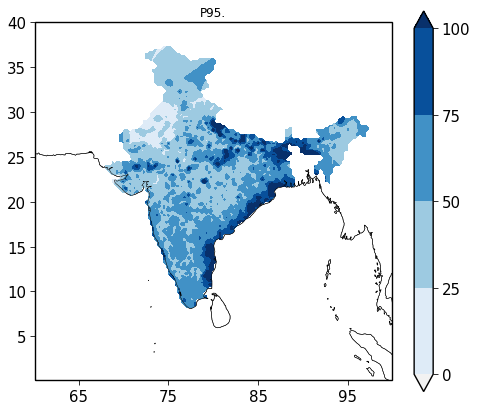

In [26]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_postmon_24['precip_median'], cmap=newblues, levels=np.arange(0, 125, 25), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

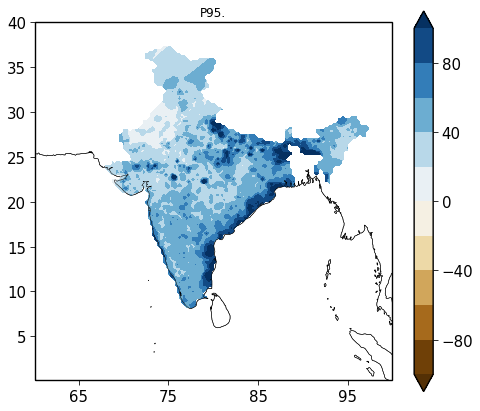

In [27]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_postmon_24['precip_anom'], cmap=BrBU, levels=np.arange(-100, 120, 20), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

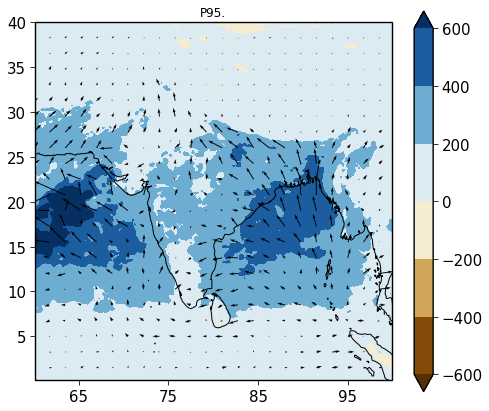

In [39]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1., color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_postmon_24['vimt_anom'], cmap=BrBU, levels=np.arange(-600, 800, 200), extend='both')
q = ax.quiver(x[::7,::7], y[::7,::7], res_postmon_24['vimtu_anom'][::7,::7], res_postmon_24['vimtv_anom'][::7,::7], scale = 10000)
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=1.0)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

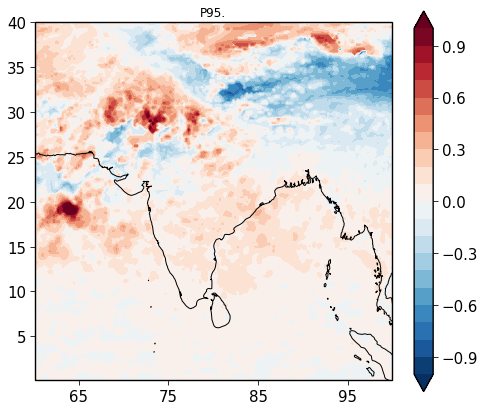

In [43]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1., color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_postmon_24['rvo200_anom']*10**4, cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=1.0)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

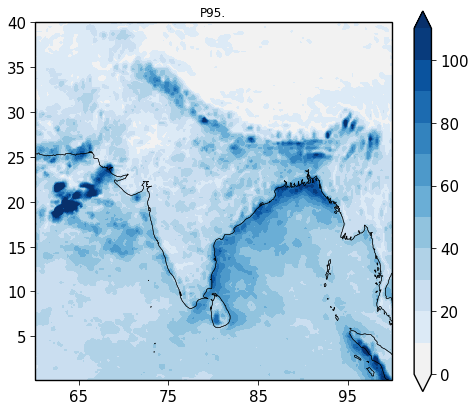

In [44]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, dyn_thermo_postmon_24['pe_median'], cmap=newblues, levels=np.arange(0, 120, 10), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

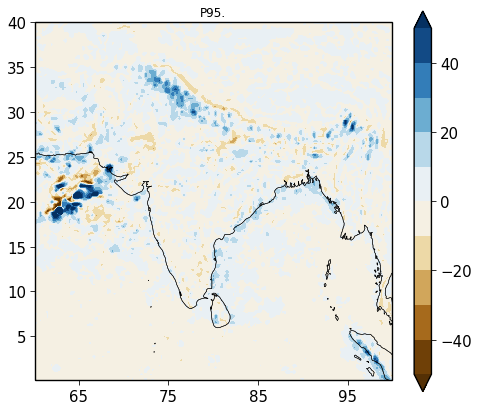

In [45]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, dyn_thermo_postmon_24['pe_median'] - dyn_thermo_postmon_24['precip_median'], cmap=BrBU, levels=np.arange(-50, 60, 10), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

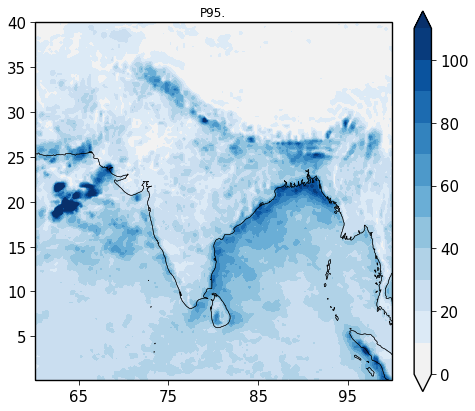

In [46]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, dyn_thermo_postmon_24['dyn_median'], cmap=newblues, levels=np.arange(0, 120, 10), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

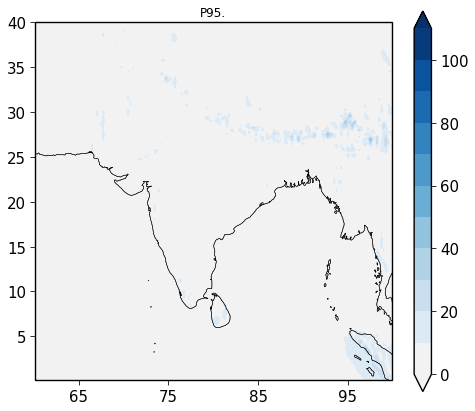

In [47]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, dyn_thermo_postmon_24['thermo_median'], cmap=newblues, levels=np.arange(0, 120, 10), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

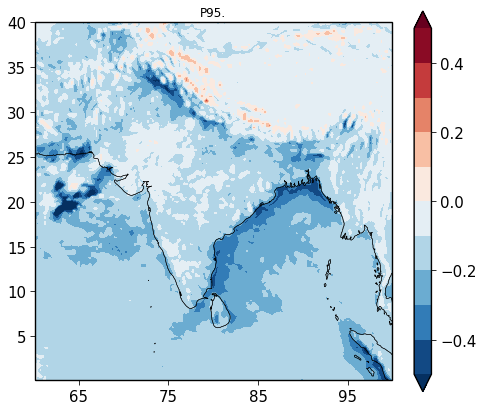

In [66]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, dyn_thermo_postmon_24['omega_median'], cmap='RdBu_r', levels=np.arange(-0.5, 0.6, 0.1), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'P95.')

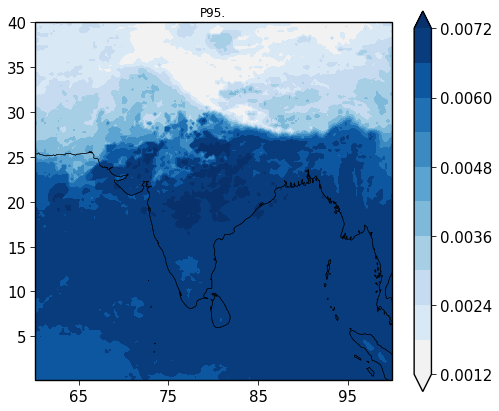

In [65]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, dyn_thermo_postmon_24['q_median'], cmap=newblues, levels=11, extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

In [28]:
for key in res_postmon_24.keys():
    with open('./data/results/imd/24H/postmon/'+key+'.npy', 'wb') as f:
        np.save(f, res_postmon_24[key]) 

Text(0.5, 1.0, 'P95.')

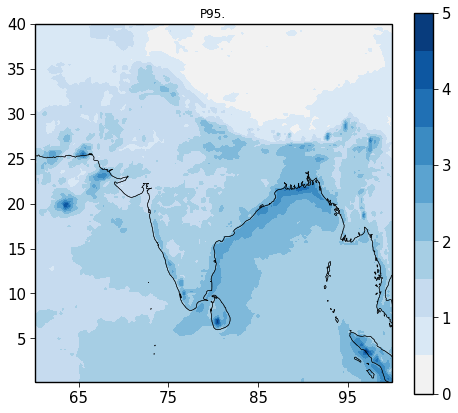

In [37]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_mon_24['precip_95'], cmap=newblues, levels=11)
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('P95.', fontsize=12)

Text(0.5, 1.0, 'Precip.')

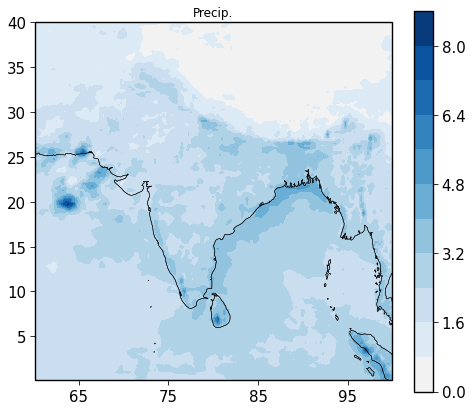

In [38]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_mon_24['precip_median'], cmap=newblues, levels=11)
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('Precip.', fontsize=12)

Text(0.5, 1.0, 'Precip. anom')

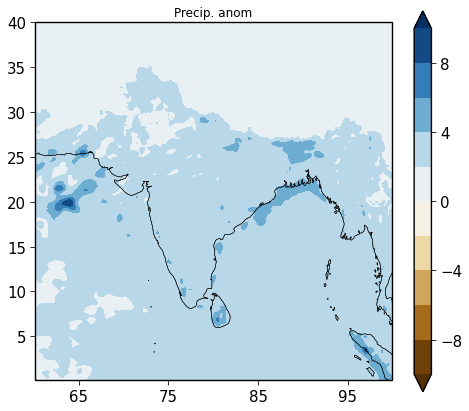

In [39]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
cf = ax.contourf(x, y, res_mon_24['precip_anom'], cmap=BrBU, levels=np.arange(-10, 12, 2), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('Precip. anom', fontsize=12)

In [40]:
# fig = plt.figure(figsize = (8,7))
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([60.1, 99.9, 0.1, 38])
# gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
# cf = ax.contourf(x, y, res_mon_24['t2m_median'], cmap='turbo', levels=11)
# plt.colorbar(cf)
# ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
# gridliner.top_labels = False
# gridliner.right_labels = False
# gridliner.ylines = False
# gridliner.xlines = False
# ax.set_yticks(np.arange(5,45,5))
# ax.set_xticks(np.arange(65,105,10))
# ax.set_title('SAT', fontsize=12)

In [41]:
# fig = plt.figure(figsize = (8,7))
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([60.1, 99.9, 0.1, 38])
# gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
# cf = ax.contourf(x, y, res_mon_24['t2m_anom'], cmap='RdBu_r', levels=np.arange(-12,14,2), extend='both')
# plt.colorbar(cf)
# ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
# gridliner.top_labels = False
# gridliner.right_labels = False
# gridliner.ylines = False
# gridliner.xlines = False
# ax.set_yticks(np.arange(5,45,5))
# ax.set_xticks(np.arange(65,105,10))
# ax.set_title('SAT anom', fontsize=12)

In [42]:
# fig = plt.figure(figsize = (8,7))
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([60.1, 99.9, 0.1, 38])
# gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
# cf = ax.contourf(x, y, res_mon_24['d2m_median'], cmap='turbo', levels=11)
# plt.colorbar(cf)
# ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
# gridliner.top_labels = False
# gridliner.right_labels = False
# gridliner.ylines = False
# gridliner.xlines = False
# ax.set_yticks(np.arange(5,45,5))
# ax.set_xticks(np.arange(65,105,10))
# ax.set_title('DPT', fontsize=12)

In [43]:
# fig = plt.figure(figsize = (8,7))
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([60.1, 99.9, 0.1, 38])
# gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
# cf = ax.contourf(x, y, res_mon_24['d2m_anom'], cmap='RdBu_r', levels=np.arange(-20,22,2), extend='both')
# plt.colorbar(cf)
# ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
# gridliner.top_labels = False
# gridliner.right_labels = False
# gridliner.ylines = False
# gridliner.xlines = False
# ax.set_yticks(np.arange(5,45,5))
# ax.set_xticks(np.arange(65,105,10))
# ax.set_title('DPT anom.', fontsize=12)

Text(0.5, 1.0, 'WS 850')

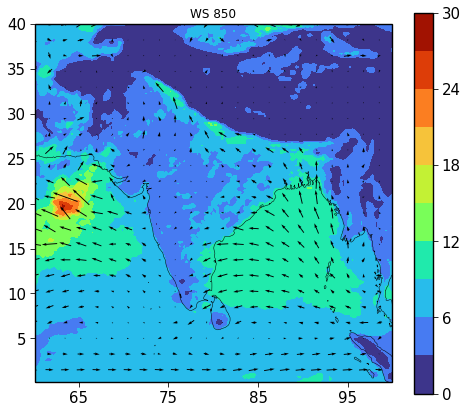

In [44]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, res_mon_24['ws850_median'], cmap='turbo', levels=9, extend='neither')
qui = ax.quiver(x[::7, ::7], y[::7, ::7], \
                (res_mon_24['u850_median'])[::7, ::7], \
                (res_mon_24['v850_median'])[::7, ::7], \
                pivot='middle', scale=250, units='width')
# quik = ax.quiverkey(qui, 0.3, 0.05, 5, '5 m/s', labelpos='N', \
#                     coordinates='figure', fontproperties={'family':'sans', 'size':12})
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
# norm = BM(np.arange(np.min(p95_2000_daily), np.max(p95_2000_daily), 10), 256, extend='neither')
# fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = ax, \
#             orientation = 'vertical')
ax.set_title('WS 850', fontsize=12)

Text(0.5, 1.0, 'WS850 anom')

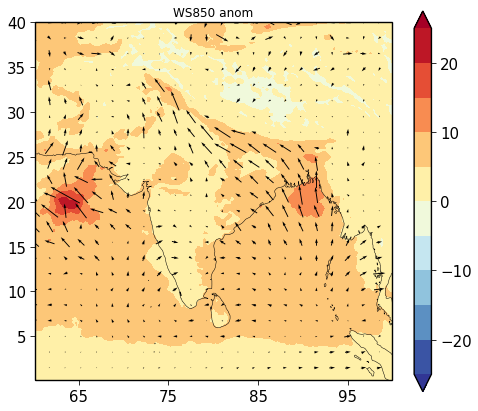

In [45]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, res_mon_24['ws850_anom'], cmap='RdYlBu_r', levels=np.arange(-25,30,5), extend='both')
qui = ax.quiver(x[::7, ::7], y[::7, ::7], \
                (res_mon_24['u850_anom'])[::7, ::7], \
                (res_mon_24['v850_anom'])[::7, ::7], \
                pivot='middle', scale=200, units='width')
# quik = ax.quiverkey(qui, 0.3, 0.05, 5, '5 m/s', labelpos='N', \
#                     coordinates='figure', fontproperties={'family':'sans', 'size':12})
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
# norm = BM(np.arange(np.min(p95_2000_daily), np.max(p95_2000_daily), 10), 256, extend='neither')
# fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = ax, \
#             orientation = 'vertical')
ax.set_title('WS850 anom', fontsize=12)

Text(0.5, 1.0, 'LLMT')

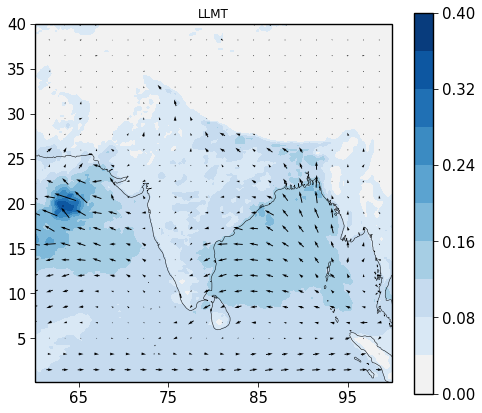

In [46]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, res_mon_24['llmt_median'], cmap=newblues, extend='neither', levels = 9)
qui = ax.quiver(x[::7, ::7], y[::7, ::7], \
                (res_mon_24['llmtu_median'])[::7, ::7], \
                (res_mon_24['llmtv_median'])[::7, ::7], \
                pivot='middle', scale=4, units='width')
# quik = ax.quiverkey(qui, 0.3, 0.05, 5, '5 m/s', labelpos='N', \
#                     coordinates='figure', fontproperties={'family':'sans', 'size':12})
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
# norm = BM(np.arange(np.min(p95_2000_daily), np.max(p95_2000_daily), 10), 256, extend='neither')
# fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = ax, \
#             orientation = 'vertical')
ax.set_title('LLMT', fontsize=12)

Text(0.5, 1.0, 'LLMT anom')

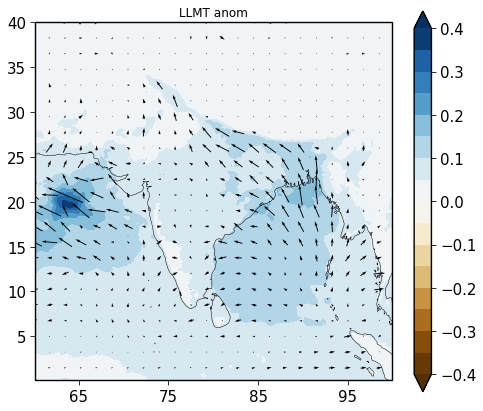

In [47]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, res_mon_24['llmt_anom'], cmap=BrBU, extend='both', levels = np.arange(-0.4, 0.45, 0.05))
qui = ax.quiver(x[::7, ::7], y[::7, ::7], \
                (res_mon_24['llmtu_anom'])[::7, ::7], \
                (res_mon_24['llmtv_anom'])[::7, ::7], \
                pivot='middle', scale=2.5, units='width')
# quik = ax.quiverkey(qui, 0.3, 0.05, 5, '5 m/s', labelpos='N', \
#                     coordinates='figure', fontproperties={'family':'sans', 'size':12})
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
# norm = BM(np.arange(np.min(p95_2000_daily), np.max(p95_2000_daily), 10), 256, extend='neither')
# fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = ax, \
#             orientation = 'vertical')
ax.set_title('LLMT anom', fontsize=12)

Text(0.5, 1.0, 'CAPE')

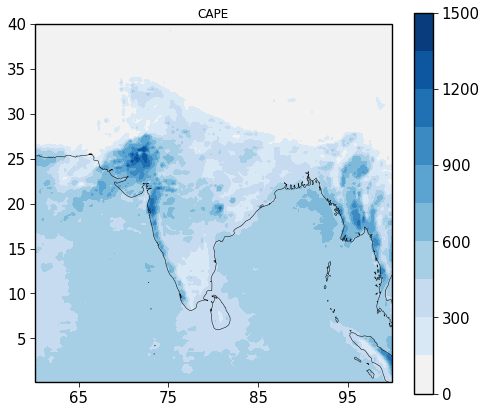

In [48]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, res_mon_24['cape_median'], cmap=newblues, levels=9)
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('CAPE', fontsize=12)

Text(0.5, 1.0, 'CAPE anom')

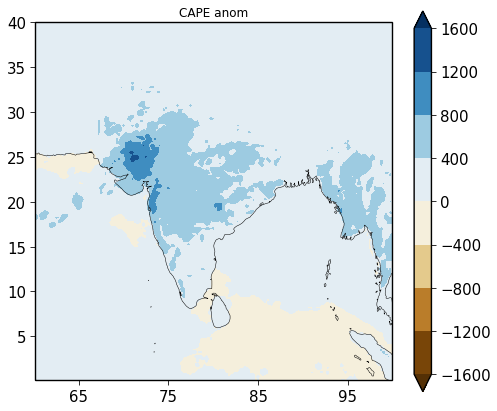

In [49]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, res_mon_24['cape_anom'], cmap=BrBU, levels=np.arange(-1600, 2000, 400), extend='both')
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('CAPE anom', fontsize=12)

Text(0.5, 1.0, 'VIMC')

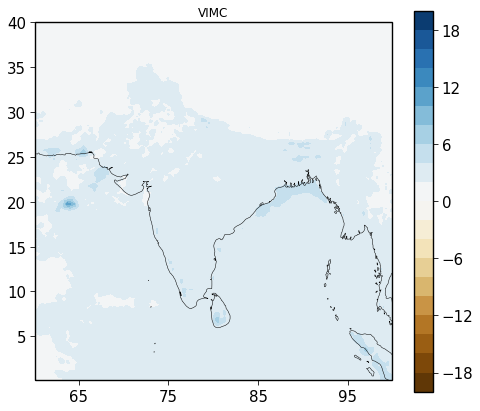

In [50]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, -res_mon_24['vimd_median'], cmap=BrBU, levels=np.arange(-20, 22, 2))
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('VIMC', fontsize=12)

Text(0.5, 1.0, 'VIMC anom')

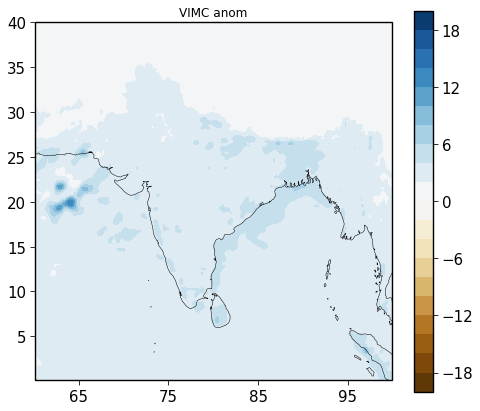

In [51]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.contourf(x, y, -res_mon_24['vimd_anom'], cmap=BrBU, levels=np.arange(-20, 22, 2))
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
ax.set_title('VIMC anom', fontsize=12)

In [52]:
# fig = plt.figure(figsize = (8,7))
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([60.1, 99.9, 0.1, 38])
# gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
# cf = ax.contourf(x, y, res_mon_24['omega_median'], cmap='RdBu', levels=np.arange(-1.5, 1.6, 0.1), extend='both')
# plt.colorbar(cf)
# ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
# gridliner.top_labels = False
# gridliner.right_labels = False
# gridliner.ylines = False
# gridliner.xlines = False
# ax.set_yticks(np.arange(5,45,5))
# ax.set_xticks(np.arange(65,105,10))
# ax.set_title('Omega850', fontsize=12)

In [53]:
# fig = plt.figure(figsize = (8,7))
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([60.1, 99.9, 0.1, 38])
# gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
# cf = ax.contourf(x, y, res_mon_24['omega_anom'], cmap='RdBu', levels=np.arange(-2, 2.1, 0.1), extend='both')
# plt.colorbar(cf)
# ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
# gridliner.top_labels = False
# gridliner.right_labels = False
# gridliner.ylines = False
# gridliner.xlines = False
# ax.set_yticks(np.arange(5,45,5))
# ax.set_xticks(np.arange(65,105,10))
# ax.set_title('Omega850 anom', fontsize=12)

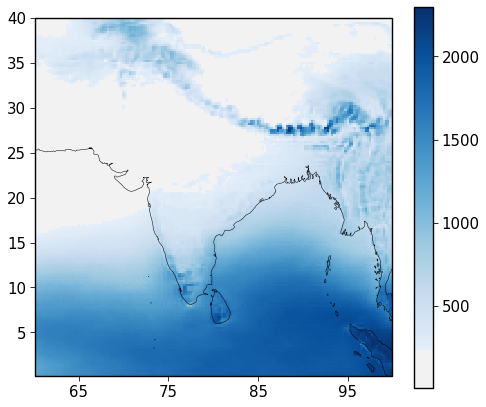

In [54]:
fig = plt.figure(figsize = (8,7))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([60.1, 99.9, 0.1, 38])
gridliner = ax.gridlines(crs = ccrs.PlateCarree(), drawlabels=False, lw=1, color='gray', alpha=0.05, ls='--')
cf = ax.pcolormesh(x, y, res_mon_24['frequency'], cmap=newblues)
plt.colorbar(cf)
ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False
gridliner.xlines = False
ax.set_yticks(np.arange(5,45,5))
ax.set_xticks(np.arange(65,105,10))
# ax.set_title('Freq.', fontsize=12)

In [55]:
for key in res_mon_24.keys():
    with open('./data/results/1H/postmon/'+key+'.npy', 'wb') as f:
        np.save(f, res_mon_24[key])